## Potato Disease Classification Using Convolutional Neural Networks

This project involves building a Convolutional Neural Network (CNN) model to classify potato plant leaves into three categories: Potato Early Blight, Potato Late Blight, and Healthy. The dataset is sourced from the PlantVillage dataset, which provides labeled images of different plant diseases. This notebook walks through the entire process, including dataset loading, preprocessing, model building, training, evaluation, and saving the trained model for future use

#### *1*. Setup and Data Loading

###### Install and Configure Kaggle API

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arjuntejaswi/plant-village


Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
 93% 306M/329M [00:02<00:00, 89.5MB/s]
100% 329M/329M [00:03<00:00, 114MB/s] 


###### Unzip and Prepare the Dataset


In [ ]:
!unzip plant-village.zip


Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-7476153023ce___YLCV_GCREC 2258.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Cur

###### Load the Potato Images


In [ ]:
import tensorflow as tf

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3

# Path to the Potato dataset
potato_dataset_dir = "/content/PlantVillage"

# Loading the Potato dataset
potato_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    potato_dataset_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset=None,
    labels='inferred',
    label_mode='int',
    class_names=["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]
)

# Displaying the class names in the dataset
class_names = potato_dataset.class_names
print(class_names)


Found 2152 files belonging to 3 classes.
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


###### Visualize Sample Images


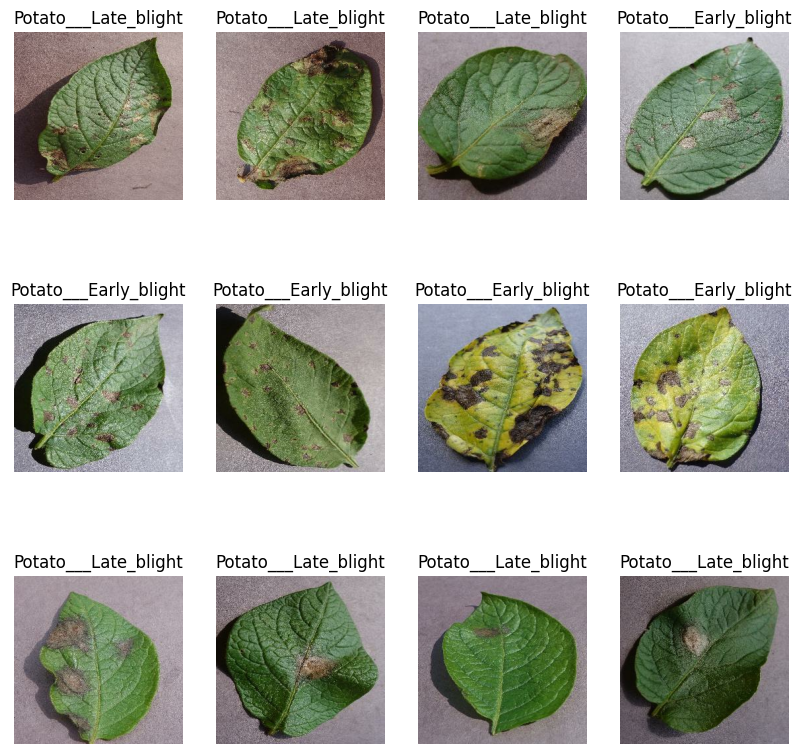

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in potato_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


#### 2. Dataset Preprocessing


###### Split the Dataset


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1, "The split ratios must sum to 1"

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(potato_dataset)

print(f"Training set size: {len(train_ds)}")
print(f"Validation set size: {len(val_ds)}")
print(f"Test set size: {len(test_ds)}")


Training set size: 54
Validation set size: 6
Test set size: 8


###### Optimize Dataset Performance


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


#### 3. Model Building


###### Construct the CNN Model


In [ ]:
from tensorflow.keras import layers, models

# Resizing and rescaling layer
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
])

# Applying data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

# Unique Model architecture
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 252, 252, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 124, 124, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 122, 122, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 27, 27, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,769,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,056,419 (11.66 MB)

 Trainable params: 3,056,419 (11.66 MB)

 Non-trainable params: 0 (0.00 B)

###### Compile the Model


In [ ]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


#### 4. Training


###### Train the Model


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 708ms/step - accuracy: 0.5030 - loss: 0.9362 - val_accuracy: 0.5625 - val_loss: 1.1285
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 566ms/step - accuracy: 0.7004 - loss: 0.7139 - val_accuracy: 0.8229 - val_loss: 0.4534
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 567ms/step - accuracy: 0.7943 - loss: 0.5197 - val_accuracy: 0.8281 - val_loss: 0.5261
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 555ms/step - accuracy: 0.7968 - loss: 0.5087 - val_accuracy: 0.8073 - val_loss: 0.5608
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 599ms/step - accuracy: 0.8160 - loss: 0.4838 - val_accuracy: 0.8073 - val_loss: 0.4694
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 550ms/step - accuracy: 0.8721 - loss: 0.3308 - val_accuracy: 0.8854 - val_loss: 0.3066
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 554ms/step - accuracy: 0.8826 - loss: 0.2966 - val_accuracy: 0.8125 - val_loss: 0.5007
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 567ms/step - accuracy: 0.8446 - loss: 0.3822 - val_accu

#### 5. Evaluation


###### Evaluate the Model


In [ ]:
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {scores[1]*100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9908 - loss: 0.0200
Test Accuracy: 98.83%


###### Evaluation Metrics


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
                       precision    recall  f1-score   support

Potato___Early_blight       0.99      1.00      1.00       134
 Potato___Late_blight       0.99      0.98      0.99       102
     Potato___healthy       0.95      0.95      0.95        20

             accuracy                           0.99       256
            macro avg       0.98      0.98      0.98       256
         weighted avg       0.99      0.99      0.99       256



#### 6. Visualization


###### Plot Accuracy and Loss Curves


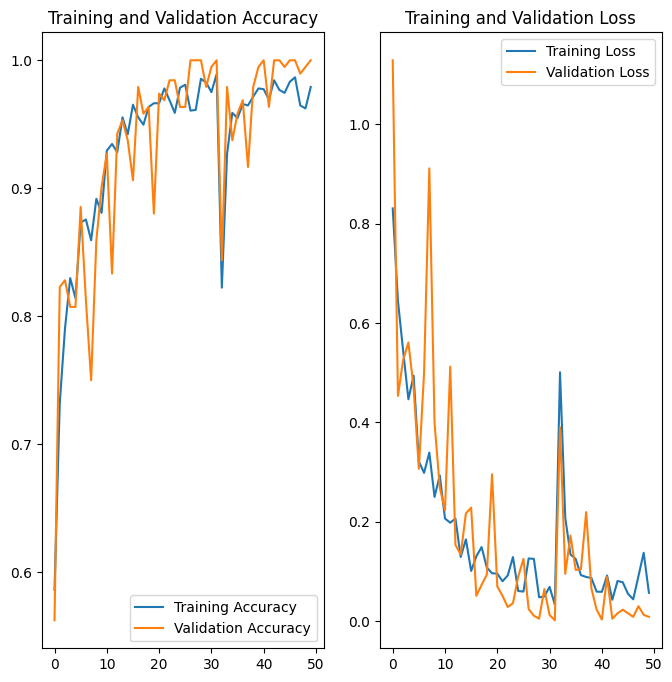

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


###### Confusion Matrix


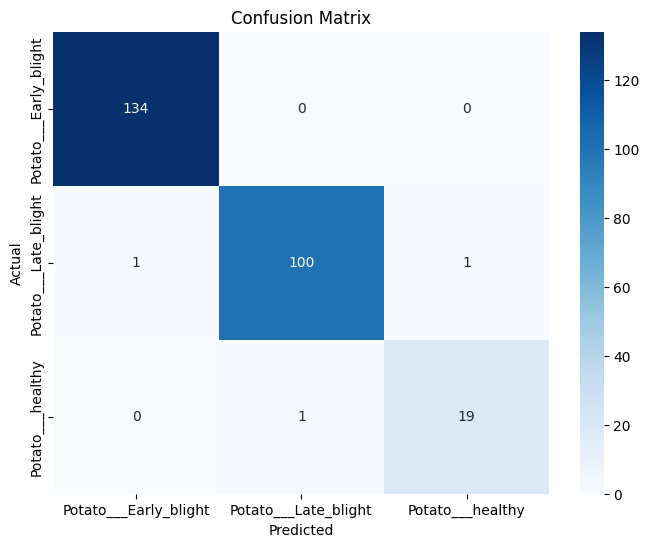

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#### 7. Prediction


###### Run a Prediction on a Sample Image


First image to predict:


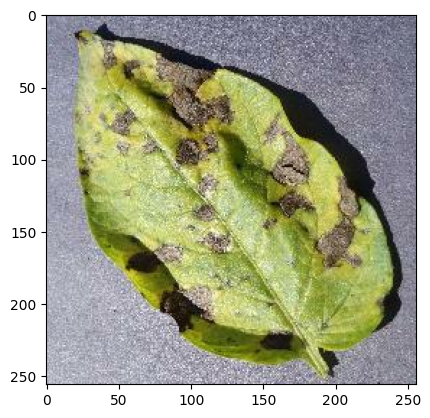

Actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
Predicted label: Potato___Early_blight


In [ ]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict:")
    plt.imshow(first_image)
    plt.show()
    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    predicted_label = class_names[np.argmax(batch_prediction[0])]
    print("Predicted label:", predicted_label)


###### Define a Prediction Function


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


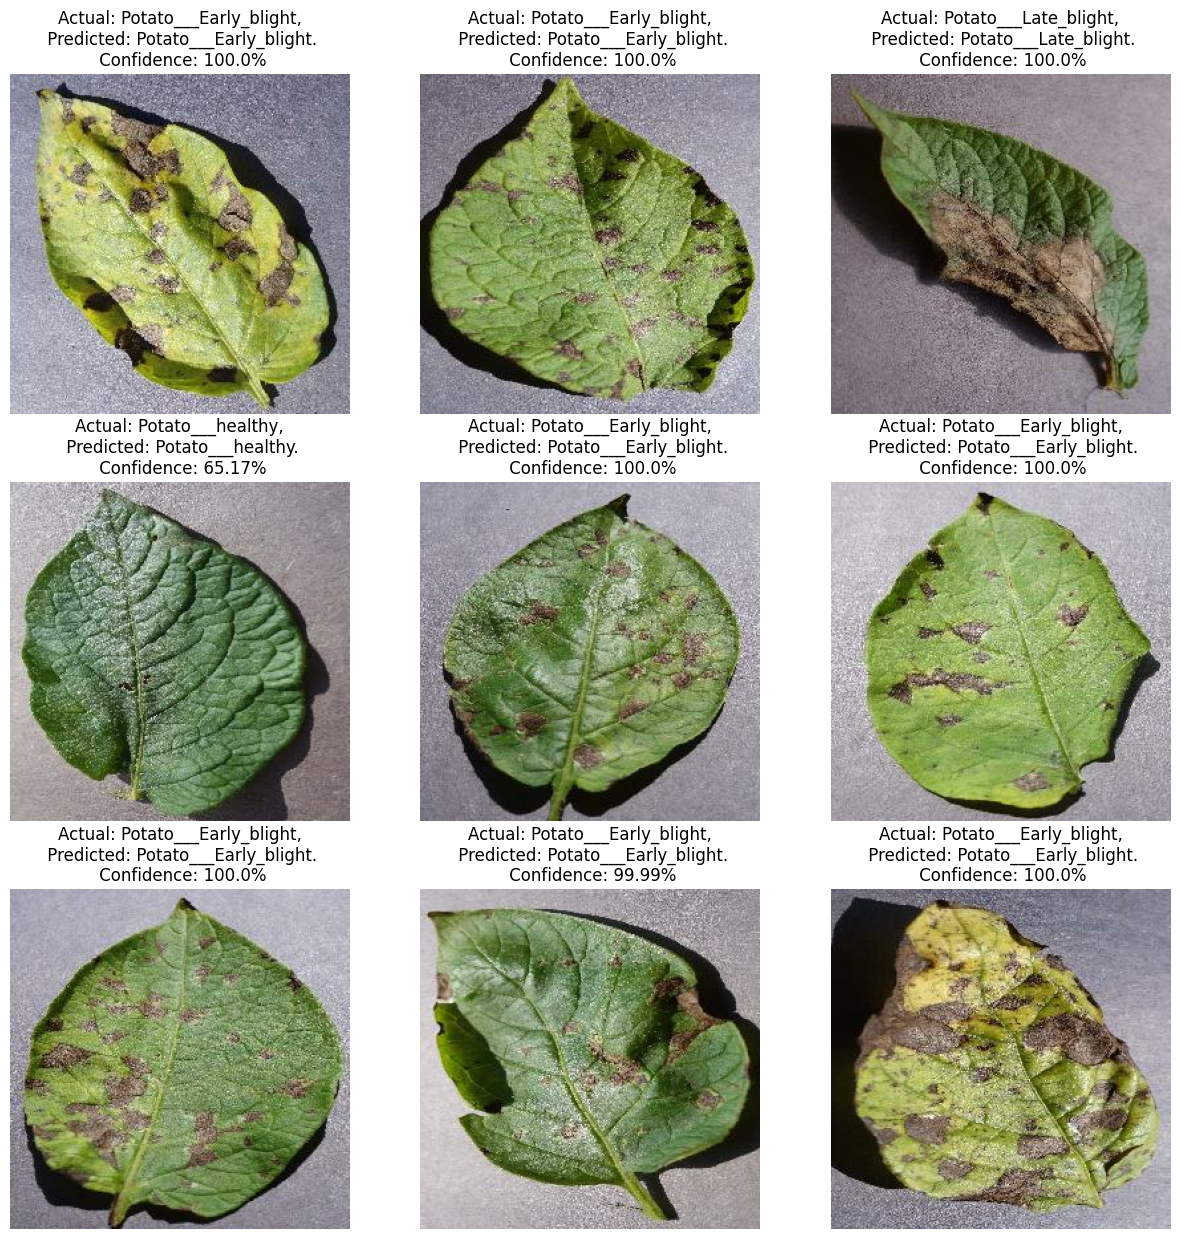

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


#### 8. Model Saving


###### Save the Model


In [ ]:
import os

if not os.path.exists("models"):
    os.makedirs("models")

model_version = max([int(i.split('.')[0]) for i in os.listdir("models") + ["0.keras"]]) + 1
model.save(f"models/{model_version}.keras")

model.save("potatoes.h5")
